#                     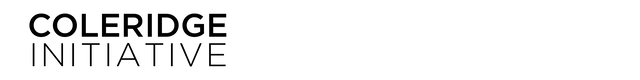

# 1. About the data

4 main pieces of data:

* train.csv: The CSV file containing all the metadata of the publications, such as their title and the dataset they utilize. 
* train: The directory containing the actual publications that are referenced in train.csv in JSON format. 
* test: The directory containing the actual publications that will be used for testing purposes (thus, with no ground truth CSV file available). 
* sample_submission.csv: The CSV file containing all the publications IDs in the test set, for which we'll have to populate the prediction column.

# 2. Some Quick General Visualizations / Interactions

### link to open an interactive dashboard to Viz the dataset 

https://jp-tok.dataplatform.cloud.ibm.com/dashboards/a2808023-27fa-4eee-9a33-80833d38d30f/view/5c38a50117b50fcd54ecc8e407917a067c622255b7bbd557d2d47b495d657497f36e1ac2c82d4b53de105366f6b8155e98

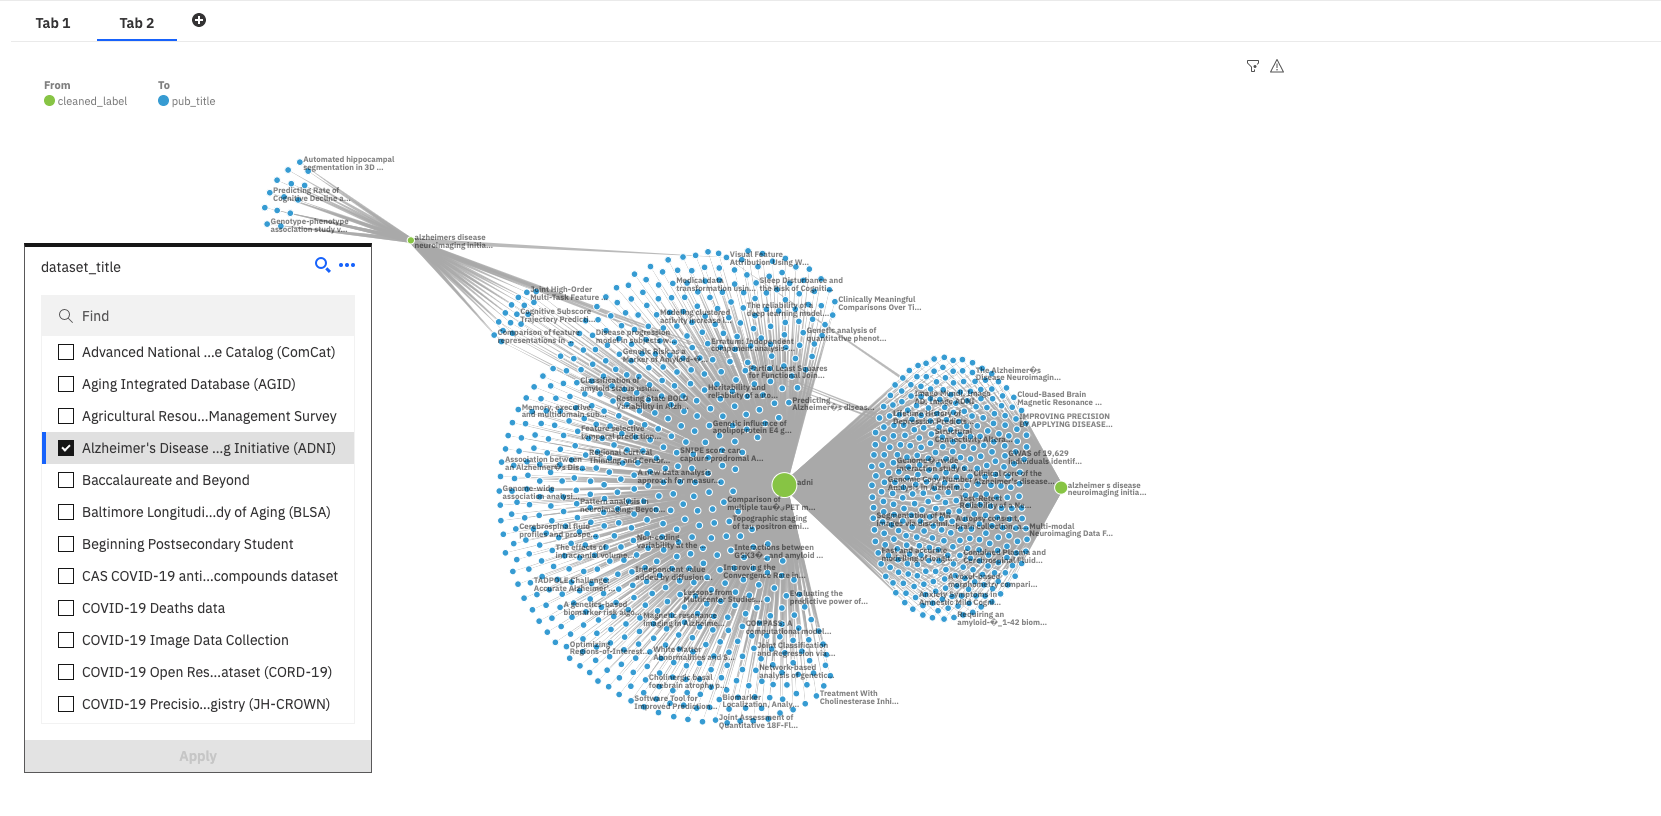

# 3. Data Exploration and Manipulation

In [ ]:
# importing libraries

import os
import re
import json
import gc
from itertools import repeat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
import glob
from collections import defaultdict
import plotly.express as px
import plotly.graph_objects as go
from tqdm.auto import tqdm


%matplotlib inline
#print(tf.__version__)
#os.listdir('/kaggle/input/coleridgeinitiative-show-us-the-data')
import warnings
warnings.simplefilter('ignore')

In [ ]:
def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower()).strip()

In [ ]:
source_path = '../input/coleridgeinitiative-show-us-the-data'

In [ ]:
# Train data csv
df = pd.read_csv(f'{source_path}/train.csv')
sample_submission_df = pd.read_csv(f'{source_path}/sample_submission.csv')
#train = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/train.csv')

In [ ]:
df.sample(3)


In [ ]:
sample_submission_df.sample(3)

In [ ]:
# text of a publication from the json file and put it in the train dataframe

def get_text(filename, test=False):
    if test:
        df = pd.read_json('../input/coleridgeinitiative-show-us-the-data/test/{}.json'.format(filename))
    else:
        df = pd.read_json('../input/coleridgeinitiative-show-us-the-data/train/{}.json'.format(filename))
    text = " ".join(list(df['text']))
    return text


In [ ]:
df['text'] = df['Id'].apply(get_text)
df.sample(5)

In [ ]:
df.info()

In [ ]:
# Unique characteristics of this dataset 

for col in df.columns:
    print(f"{col}: {len(df[col].unique())}")

In [ ]:
print("pub_title:",len(df['pub_title'].unique()))
print("ID:",len(df['Id'].unique()))
print("diff btw pub_title and Id:",len(df['Id'].unique()) - len(df['pub_title'].unique()))
print("diff btw text - Id:" ,len(df['Id'].unique()) - len(df['text'].unique()))

#### * There are 14,316 unique IDs in the dataset
#### * There is a difference in total between ID and pub_title of 45, which means that pub_title is slightly smaller than the number of ID when we applied the unique counts. 
#### * There are a total of 45 unique dataset_title and 130 unique dataset_label. Meaning that a single dataset could have multiple labels throughout different publications.
#### * The difference btw 'text' column and the 'Id' is equal to 15, meaning  that there are slight more IDs than text.

## 3.1 'pub_title' words exploration & analysis of words within

In [ ]:
#cleaning publication title to small caps letters

df['cleaned_pub_title']= df.pub_title.apply(lambda x: clean_text(x))

In [ ]:
# The new cleaned date columns as cleaned_label and cleaned_pub_titile
df.head()

## 3.1.1 Exploring the length of cleaned_pub_title

In [ ]:
df['pub_title_len'] = df.cleaned_pub_title.apply(lambda x: len(x))

In [ ]:
# New column added to know the exact length of each pub_title
df

In [ ]:
#Checking for the lenght argmax() of pub_title

print(f'Length: {len(df.iloc[df.pub_title_len.argmax()].cleaned_pub_title)}')
print(f'Publication title: {df.iloc[df.pub_title_len.argmax()].cleaned_pub_title}')


In [ ]:
#Checking for the lenght argmin() of pub_title

print(f'Length: {len(df.iloc[df.pub_title_len.argmin()].cleaned_pub_title)}')
print(f'Publication title: {df.iloc[df.pub_title_len.argmin()].cleaned_pub_title}')


## 3.1.2 Calculating lenght: cl_label_len on cleaned_label

In [ ]:
df['cl_label_len'] = df.cleaned_label.apply(lambda x: len(x))

In [ ]:
#Checking for the lenght argmax() of cleaned_label

print(f'Length: {len(df.iloc[df.cl_label_len.argmax()].cleaned_label)}')
print(f'Publication title: {df.iloc[df.cl_label_len.argmax()].cleaned_label}')

In [ ]:
#Checking for the lenght argmax() of cleaned_label

print(f'Length: {len(df.iloc[df.cl_label_len.argmin()].cleaned_label)}')
print(f'Publication title: {df.iloc[df.cl_label_len.argmin()].cleaned_label}')

## 3.1.3 Calculating the len dataset_title as dta_title_len

In [ ]:
df['dta_title_len'] = df.dataset_title.apply(lambda x: len(x))

In [ ]:
df.sample(3)

## 3.1.4 Exploring 'text' column

In [ ]:
tqdm.pandas()

df['text'] = df['text'].progress_apply(clean_text)


In [ ]:
tqdm.pandas()
sample_submission_df['text'] = sample_submission_df['Id'].progress_apply(get_text)

In [ ]:
sample_submission_df

## 3.1.5 Lenght of publications (text_len) full publications

In [ ]:
df['text_len'] = df.text.apply(lambda x: len(x))
df.sample(3)

# 4. Filtering Frq on 'ID' column to understand multiple pub in different datasets

In [ ]:
df['Id'].value_counts().to_frame()

In [ ]:
filt = df['Id'].str.contains("430aa11c-0283-411b-8edc-08f5df3db258", na=False)
df.loc[filt, 'Id'].value_counts()

In [ ]:
df1 = df.loc[filt]
#df.loc[filt, 'cleaned_label'].to_frame()
df1[['Id', 'dataset_title', 'cleaned_label','text_len', 'pub_title_len']]

In [ ]:
filte = df['Id']=="335a83a5-0fc0-4820-881b-5e086deb2894"
df.loc[filte]

# 5. Split data for training and testing / Build Model

In [ ]:
from sklearn.model_selection import train_test_split
dev, val = train_test_split(df, test_size=0.1, random_state=0)
print("Development: ", dev.shape)
print("Validation: ", val.shape)

# 6. Simple Baseline/Model 

In [ ]:

def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower()).strip()

temp_0 = [x.lower() for x in df['dataset_title'].unique()]
temp_1 = [x.lower() for x in df['cleaned_label'].unique()]
temp_2 =  [x.lower() for x in df['Id'].unique()]
existing_labels = set(temp_0 + temp_1 + temp_2)
labels = existing_labels
id_list = []
lables_list = []
gt =[]
for index, row in tqdm(sample_submission_df.iterrows()):
    sample_text = row['text']
    row_id = row['Id']
    temp_df = df[df['text'] == clean_text(sample_text)]
    cleaned_labels = temp_df['cleaned_label'].to_list()
    gt.append(cleaned_labels)
    for known_label in existing_labels:
        if known_label in sample_text.lower():
            cleaned_labels.append(clean_text(known_label))
    cleaned_labels = [clean_text(x) for x in cleaned_labels]
    cleaned_labels = set(cleaned_labels)
    lables_list.append(' | '.join(cleaned_labels))
    id_list.append(row_id)


In [ ]:
submission = pd.DataFrame()
submission['Id'] = id_list
submission['prediction_string'] = lables_list
submission['ground_truth'] = gt


In [ ]:
submission

#### Checking results sample

In [ ]:
filt = df['Id'].str.contains('3f316b38-1a24-45a9-8d8c-4e05a42257c6', na = False)
df.loc[filt, 'cleaned_label'].to_frame()

reference: https://www.kaggle.com/harshsharma511/start-to-end-easy-understanding-eda-model

In [ ]:
df_shuffled = df.sample(frac = 1, random_state=42)# shuffle with random_state=42 for reproducibility
df_shuffled.sample(3)

In [ ]:
df_shuffled.info()

In [ ]:
df_shuffled.describe()

In [ ]:
# let visualize  some random training samples
import random
random_index = random.randint(0, len(df)-5)  # create random indexes not higher than the total number of samples
print(f"The number of random samples are: {random_index}\n")

for row in df_shuffled[['Id', 'text_len']][random_index:random_index+4].itertuples(): # +10 control the printing of sample
  _, Id, text_len = row
  print(f"text_len: {text_len}", "(matched)") if text_len == text_len  else ("no match")
  print(f"Id:\n{Id}\n")
  print("---\n")

In [ ]:
from sklearn.model_selection import train_test_split

#Use  train test split to split traing data into training a validation sets
train_sentences, val_sentences,train_labels,val_labels = train_test_split(
    df_shuffled.dataset_title.to_numpy(), 
    df_shuffled.cleaned_label.to_numpy(),
    test_size = 0.2, # dedicate 10% of samples to validation set
    random_state = 42 # random state for reproducibility
)

In [ ]:
#check the lenght or shape
print(train_sentences.shape, val_sentences.shape, train_labels.shape, val_labels.shape)

#### Text Tokenization

In [ ]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

#Use the default Textvectorization

text_vectorizer = TextVectorization(max_tokens = 10000, # how many words in the vocabulary (all of the different words in your text)
                                    standardize = 'lower_and_strip_punctuation', # how to process text
                                    split = 'whitespace',# how to split token
                                    ngrams = None, #create group o n-word?
                                    output_mode = 'int', #how to map tokens to numbers
                                    output_sequence_length =  None, ## how long should the output sequence of tokens be?
                                    pad_to_max_tokens = True)

text_vectorizer 

In [ ]:
# find avg # of takens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

In [ ]:
max_vocab_length = 10000 #  max number of words to have in our vocabulary
max_length = 5 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [ ]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)


In [ ]:
# Create sample sentence and tokenize it
sample_sentence = "alzheimer s disease neuroimaging initiative adni"
text_vectorizer([sample_sentence])

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_10_words = words_in_vocab[:10] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_10_words = words_in_vocab[-10:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 10 most common words: {top_10_words}") 
print(f"Bottom 10 least common words: {bottom_10_words}")

### Creating an Embedding (layer)

In [ ]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length) # how long is each input

embedding

In [ ]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed
sample_embed [0][0]# look up a single token's embedding

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#create a tokenization a modelling pipeline
model_0 = Pipeline([
                    ('tfidf', TfidfVectorizer()),#convert words to munbers using tfid
                    ('clf', MultinomialNB())# model the text
])

#fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

In [ ]:
muiltinomialB = model_0.score(val_sentences, val_labels)
print(f" Our baseline model achieved an accuracy of: {muiltinomialB}") #*100:.2f}%")

In [ ]:
# How about make some predictions for our baseline model

baseline_preds = model_0.predict(val_sentences)
baseline_preds[:2]

In [ ]:
# function evealuate: accuracy. precission, recall, f1_score

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) #* 100
  # Calculate model precision, recall and f1 score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted",labels=np.unique(y_pred))
    model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
    return model_results

In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
output = baseline_results

In [ ]:
output